# Car sales real life example

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
sns.set()

In [2]:
# Load data
raw_data = pd.read_csv('reallifeexample.csv')
raw_data.head()

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
0,BMW,4200.0,sedan,277,2.0,Petrol,yes,1991,320
1,Mercedes-Benz,7900.0,van,427,2.9,Diesel,yes,1999,Sprinter 212
2,Mercedes-Benz,13300.0,sedan,358,5.0,Gas,yes,2003,S 500
3,Audi,23000.0,crossover,240,4.2,Petrol,yes,2007,Q7
4,Toyota,18300.0,crossover,120,2.0,Petrol,yes,2011,Rav 4


In [3]:
raw_data.describe(include='all') # also show categorical data

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
count,4345,4173.000000,4345,4345.000000,4195.000000,4345,4345,4345.000000,4345
unique,7,NaN,6,NaN,NaN,4,2,NaN,312
top,Volkswagen,NaN,sedan,NaN,NaN,Diesel,yes,NaN,E-Class
freq,936,NaN,1649,NaN,NaN,2019,3947,NaN,199
mean,NaN,19418.746935,NaN,161.237284,2.790734,NaN,NaN,2006.550058,NaN
std,NaN,25584.242620,NaN,105.705797,5.066437,NaN,NaN,6.719097,NaN
min,NaN,600.000000,NaN,0.000000,0.600000,NaN,NaN,1969.000000,NaN
25%,NaN,6999.000000,NaN,86.000000,1.800000,NaN,NaN,2003.000000,NaN
50%,NaN,11500.000000,NaN,155.000000,2.200000,NaN,NaN,2008.000000,NaN
75%,NaN,21700.000000,NaN,230.000000,3.000000,NaN,NaN,2012.000000,NaN


### Handle useless features and missing values

In [6]:
# Remove useless vars
# Model can be removed since it can already be derived from Brand, Year and EngineV
data = raw_data.drop(['Model'],axis=1)

In [8]:
# Spot missing values
data.isnull().sum()

Brand             0
Price           172
Body              0
Mileage           0
EngineV         150
Engine Type       0
Registration      0
Year              0
dtype: int64

In [9]:
# Drop missing values
data_no_mv = data.dropna(axis=0) # drop observations not columns

### Handle outliers

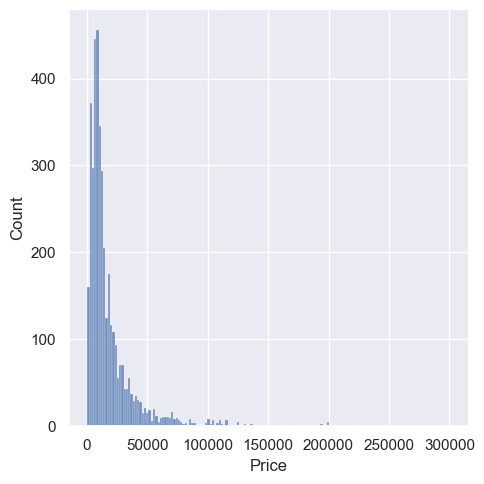

In [11]:
# Explore PDFs => distribution is not normal and there is outliers
sns.displot(data_no_mv['Price'])

In [20]:
# Remove outliers 
q = data_no_mv['Price'].quantile(0.99) # keep values below 99th percentile
data_1 = data_no_mv[data_no_mv['Price']<q]
q = data_1['Mileage'].quantile(0.99)
data_2 = data_1[data_1['Mileage']<q]
data_3 = data_2[data_2['EngineV']<6.5] # here we know the common maximum value for engine
q = data_3['Year'].quantile(0.01) # here the outliers are on the left side
data_4 = data_3[data_3['Year']>q]
data_cleaned = data_4.reset_index(drop=True) # forgot indexes for observations we just removed

### OLS assumptions : Linearity, Normality and Homoscedasticity

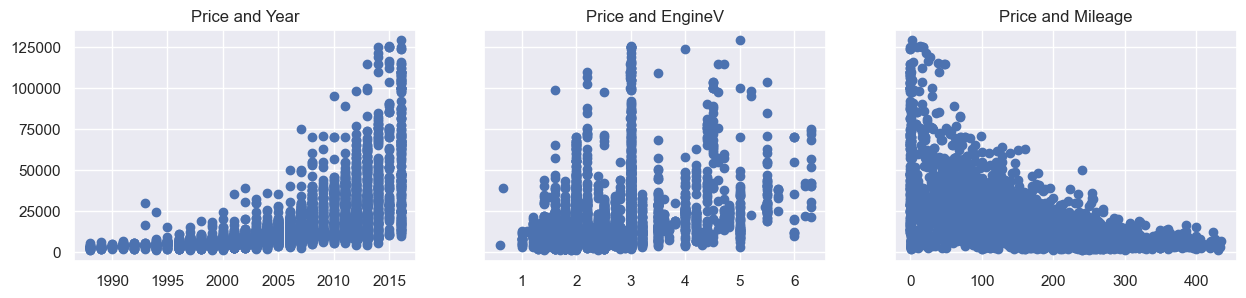

In [22]:
# Scatter plot features against Price
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize =(15,3))
ax1.scatter(data_cleaned['Year'], data_cleaned['Price'])
ax1.set_title('Price and Year')
ax2.scatter(data_cleaned['EngineV'],data_cleaned['Price'])
ax2.set_title('Price and EngineV')
ax3.scatter(data_cleaned['Mileage'], data_cleaned['Price'])
ax3.set_title('Price and Mileage')
plt.show()

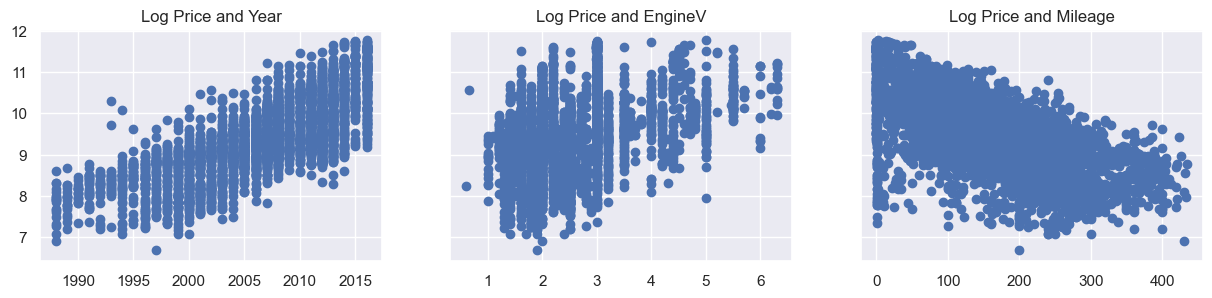

In [25]:
# Scatter plots are exponential, due to non normal distributions => use log transformations to fix
log_price = np.log(data_cleaned['Price'])
data_cleaned['log_price'] = log_price
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize =(15,3))
ax1.scatter(data_cleaned['Year'], data_cleaned['log_price'])
ax1.set_title('Log Price and Year')
ax2.scatter(data_cleaned['EngineV'],data_cleaned['log_price'])
ax2.set_title('Log Price and EngineV')
ax3.scatter(data_cleaned['Mileage'], data_cleaned['log_price'])
ax3.set_title('Log Price and Mileage')
data_cleaned = data_cleaned.drop(['Price'], axis=1)
plt.show() # now we can see linear patterns

### OLS asumptions : No autocorrelation

Our use-case is safe, not coming from time series data or panel data, each row comes from a different customer => no reason for the observations to be dependant on each others

### OLS asumptions : No multicollinearity

In [29]:
# Year and Mileage will be correlated =>  use VIF (variance inflation factor)
from statsmodels.stats.outliers_influence import variance_inflation_factor
variables = data_cleaned[['Mileage', 'Year', 'EngineV']]
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif['features'] = variables.columns
vif # if vif = 1 no multicollinearity, if 1 < vif < 5 ok, if vif > 10 unacceptable

,VIF,features
0,3.791584,Mileage
1,10.354854,Year
2,7.662068,EngineV


In [31]:
# Year is definitively too correlated, we remove it
data_no_multicollinearity = data_cleaned.drop(['Year'], axis=1)

### Handle categorical vars

In [36]:
# If we have N categories for a feature, we only need N-1 dummies, otherwise we introduce multicollinearity
data_with_dummies = pd.get_dummies(data_no_multicollinearity, drop_first=True)
cols = ['log_price', 'Mileage', 'EngineV', 'Brand_BMW',
       'Brand_Mercedes-Benz', 'Brand_Mitsubishi', 'Brand_Renault',
       'Brand_Toyota', 'Brand_Volkswagen', 'Body_hatch', 'Body_other',
       'Body_sedan', 'Body_vagon', 'Body_van', 'Engine Type_Gas',
       'Engine Type_Other', 'Engine Type_Petrol', 'Registration_yes']
data_preprocessed = data_with_dummies[cols]
data_preprocessed.head()

,log_price,Mileage,EngineV,Brand_BMW,Brand_Mercedes-Benz,Brand_Mitsubishi,Brand_Renault,Brand_Toyota,Brand_Volkswagen,Body_hatch,Body_other,Body_sedan,Body_vagon,Body_van,Engine Type_Gas,Engine Type_Other,Engine Type_Petrol,Registration_yes
0,8.342840,277,2.0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1
1,8.974618,427,2.9,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
2,9.495519,358,5.0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1
3,10.043249,240,4.2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
4,9.814656,120,2.0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1


### Linear regression model

In [39]:
targets = data_preprocessed['log_price']
inputs = data_preprocessed.drop(['log_price'], axis=1)

In [40]:
# Scale
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(inputs)
inputs_scaled = scaler.transform(inputs) # ideally we should not scale dummies

In [41]:
# Test-train split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(inputs_scaled, targets, test_size = 0.2, random_state=42)

### Train

In [42]:
# Log-linear regression
reg = LinearRegression()
reg.fit(x_train,y_train)

LinearRegression()

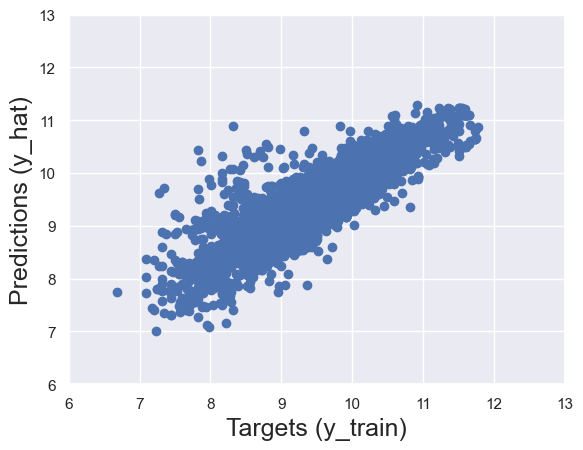

In [44]:
# Plot the predictions
y_hat = reg.predict(x_train)
plt.scatter(y_train, y_hat)
plt.xlabel('Targets (y_train)', size=18)
plt.ylabel('Predictions (y_hat)', size=18)
plt.xlim(6,13)
plt.ylim(6,13)
plt.show()

Text(0.5, 1.0, 'Residuals PDF')

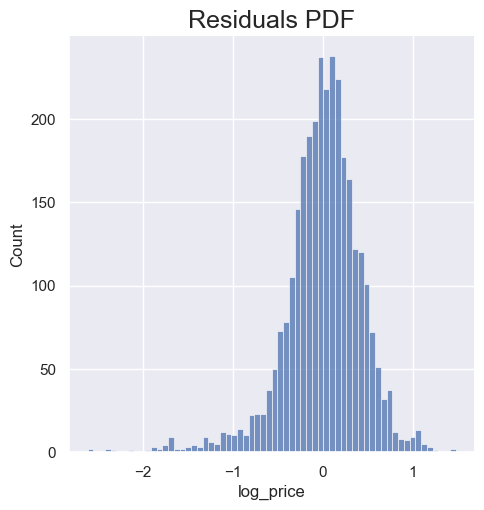

In [45]:
# Plot the residuals = differences between targets and predictions
sns.displot(y_train - y_hat)
plt.title('Residuals PDF', size=18)

In [46]:
# R-squared
reg.score(x_train, y_train)

0.7546487921881218

In [47]:
# Bias
reg.intercept_

9.421003614148074

In [51]:
# Weights
reg_summary = pd.DataFrame(inputs.columns.values, columns=['Features'])
reg_summary['Weights'] = reg.coef_
reg_summary

# Interpretation

# Continous variables
# positive weight: ++ feature value => ++ log_price and Price
# negative weight: ++ feature value => -- log_price and Price

# Dummies
# positive weight: respective category (brand) is more expensive than benchmark (Audi)
# negative weight: respective category (brand) is less expensive than benchmark (Audi)

,Features,Weights
0,Mileage,-0.468156
1,EngineV,0.215268
2,Brand_BMW,0.011052
3,Brand_Mercedes-Benz,0.005692
4,Brand_Mitsubishi,-0.142472
5,Brand_Renault,-0.187693
6,Brand_Toyota,-0.065297
7,Brand_Volkswagen,-0.098989
8,Body_hatch,-0.139808
9,Body_other,-0.093845


### Test

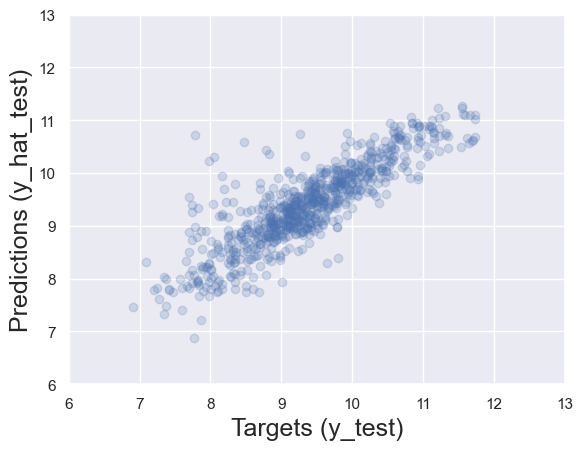

In [54]:
y_hat_test = reg.predict(x_test)
plt.scatter(y_test, y_hat_test, alpha=0.2)
plt.xlabel('Targets (y_test)', size=18)
plt.ylabel('Predictions (y_hat_test)', size=18)
plt.xlim(6,13)
plt.ylim(6,13)
plt.show()

In [55]:
# Data frame performance
no_log = np.exp(y_hat_test) # revert log
df_pf = pd.DataFrame(no_log, columns=['Predictions'])
df_pf.head()

,Predictions
0,40419.308971
1,7956.895960
2,5757.284408
3,9765.810605
4,7027.363814


In [57]:
y_test = y_test.reset_index(drop=True) # prevent Pandas form trying to match original indices
df_pf['Target'] = np.exp(y_test)
df_pf.head()

,Predictions,Target
0,40419.308971,21300.0
1,7956.895960,8900.0
2,5757.284408,3250.0
3,9765.810605,12000.0
4,7027.363814,5400.0


In [62]:
df_pf['Residual'] = df_pf['Target'] - df_pf['Predictions']
df_pf['Difference%'] = np.absolute(df_pf['Residual']/df_pf['Target']*100)
df_pf.sort_values(by=['Difference%'])

,Predictions,Target,Residual,Difference%
387,13602.753468,13600.0,-2.753468,0.020246
74,28889.063628,28900.0,10.936372,0.037842
314,35530.207664,35500.0,-30.207664,0.085092
336,11313.265936,11300.0,-13.265936,0.117398
425,2995.676139,3000.0,4.323861,0.144129
...,...,...,...,...
713,13941.933769,2200.0,-11741.933769,533.724262
280,39469.510133,4800.0,-34669.510133,722.281461
219,27632.396163,2900.0,-24732.396163,852.841247
750,30076.594470,3150.0,-26926.594470,854.812523


In [63]:
df_pf.describe()

,Predictions,Target,Residual,Difference%
count,774.000000,774.000000,774.000000,774.000000
mean,16113.011638,17799.988992,1686.977355,42.085282
std,13326.229797,19723.434542,11192.614496,96.169928
min,967.030415,999.000000,-42859.020603,0.020246
25%,7467.591694,6700.000000,-2246.354353,11.024941
50%,11914.358989,11050.000000,-38.697776,24.086183
75%,20249.505640,20475.000000,3004.524837,42.381716
max,79026.348020,125000.000000,81051.158885,1785.792525
